In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

# Data transformation
purpose of this notebook is to transform the data into a format that is suitable for the model
Initial data format:

Initil data format: \
(u_id, timestamp, lat, lon, acc)
245.304.797 rows × 5 columns

goal: \
(u_id, year, month, day, hour, lat_grid_no, lon_grid_no, (POI))

steps:

**Step One**: Calculate stoplocation for every user (see notebook: stoplocation.ipynb) \
(u_id, timestamp, lat, lon, stoplocation) \
**Step Two**: Discretise timestamp and group by hour, choose the stop location that occurs most often in that hour \
(u_id, year, month, day, hour, lat, lon, acc, stoplocation) \
**Step Three**: Define grid cells, add them to the data set, remove lat, lon and stoplocation number \
(u_id, year, month, day, hour, lat_grid_no, lon_grid_no)



In [2]:
# read dataframe from csv or pickle
df = pd.read_pickle('../data/stoplocation.pkl') # faster

In [3]:
df.head()

,user,timestamp,latitude,longitude,accuracy,stoplocation
0,153.0,1.386241e+09,55.783641,12.518414,30.689,206
1,153.0,1.386241e+09,55.783681,12.518372,28.185,206
2,153.0,1.386241e+09,55.783646,12.518382,30.841,206
3,153.0,1.386241e+09,55.783648,12.518408,21.368,206
4,153.0,1.386242e+09,55.783680,12.518435,21.000,206


In [4]:
# remove accuracy column
df = df.drop('accuracy', axis=1)

## Step 2
Discretise timestamp and group by hour, choose the stop location that occurs most often in that hour \
(u_id, year, month, day, hour, lat, lon, acc, stoplocation) \

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# create four columns from timestamp: year, month, day and hour
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

In [6]:
# add 30 minutes intervals to dataframe
df['30min_interval'] = df['timestamp'].dt.floor('30min')
# convert to 1, 2, 3, 4
df['30min_interval'] = df['30min_interval'].dt.minute / 30 + 1

In [7]:
df

,user,timestamp,latitude,longitude,stoplocation,year,month,day,hour,30min_interval
0,153.0,2013-12-05 10:51:31,55.783641,12.518414,206,2013,12,5,10,2.0
1,153.0,2013-12-05 10:51:34,55.783681,12.518372,206,2013,12,5,10,2.0
2,153.0,2013-12-05 10:56:46,55.783646,12.518382,206,2013,12,5,10,2.0
3,153.0,2013-12-05 11:00:49,55.783648,12.518408,206,2013,12,5,11,1.0
4,153.0,2013-12-05 11:05:36,55.783680,12.518435,206,2013,12,5,11,1.0
...,...,...,...,...,...,...,...,...,...,...
245304792,99.0,2014-07-29 09:40:41,55.740993,12.494146,1,2014,7,29,9,2.0
245304793,99.0,2014-07-29 09:40:41,55.740994,12.494182,1,2014,7,29,9,2.0
245304794,99.0,2014-07-29 09:40:41,55.740994,12.494161,1,2014,7,29,9,2.0
245304795,99.0,2014-07-29 09:43:22,55.740950,12.494317,1,2014,7,29,9,2.0


In [8]:
# Group by 'user' and calculate mean for 'latitude' and 'longitude'
average_locations = df.groupby(['user', 'stoplocation'])[['latitude', 'longitude']].mean().reset_index()

# Rename the columns to indicate these are averages
average_locations.rename(columns={'latitude': 'avg_latitude', 'longitude': 'avg_longitude'}, inplace=True)

In [9]:
df = df.merge(average_locations, on=['user', 'stoplocation'], how='left')


In [ ]:
# group by user year month, day, hour and 30min_interval and select the first row
df = df.groupby(['user', 'year', 'month', 'day', 'hour', '30min_interval']).first().reset_index()

In [ ]:
# remove latitude and longitude columns and rename the average columns
df.drop(columns=['latitude', 'longitude'], inplace=True)
df.rename(columns={'avg_latitude': 'latitude', 'avg_longitude': 'longitude'}, inplace=True)

In [ ]:
df

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609
...,...,...,...,...,...,...,...,...,...,...
12827787,851.0,2015,8,7,20,1.0,2015-08-07 20:03:13,26,56.123877,9.849060
12827788,851.0,2015,8,7,20,2.0,2015-08-07 20:33:14,26,56.123877,9.849060
12827789,851.0,2015,8,7,21,1.0,2015-08-07 21:03:15,26,56.123877,9.849060
12827790,851.0,2015,8,7,21,2.0,2015-08-07 21:33:15,26,56.123877,9.849060


Description of Step 2:

In the given data set each user $u$ has an individual trajectory $T_u$ consisting of a sequence of points $p_i$ with $i \in \{1, ..., n\}$, where $n$ is the number of GPS points in the trajectory. Each point $p_i$ is a 4-tuple defined by a timestamp $t_i$, a latitude $lat_i$, a longitude $lon_i$ and the according stoplocation $s_i$ that was calculated by the stop location algorithm. For each user, the stoplocations consist of positive numbers and $-1$, if the point lies on on a travel between two locations. The goal of this step is to discretise the timestamp and the location.

1. Timestamp: We discretise the timestamp by splitting it into year, month, day and hour and 15 minute intervall. For each 15 interval, the stoplocation is determined as the most frequent occuring stop location in the according interval. The location is then determined by the average of the coordinates that belong to the most frequent stoplocation. That can be written as follows. For an interval $I_j$ with $j \in \{1, ..., J\}$, where J is the total number of 15 minute intervals, is determined as follows:
$$
avg\_lat = \frac{\sum_{i=}^{n} lat_i}{n} 
$$


 group the GPS points by hour. For each hour the stop location that occurs most often is chosen as the stop location for that hour. The result is a new data set $T_u'$ for each user $u$ consisting of a sequence of GPS points $p_i'$ with $i \in \{1, ..., n'\}$, where $n'$ is the number of GPS points in the new trajectory. Each GPS point $p_i'$ is defined by a timestamp $t_i'$, a latitude $lat_i'$, a longitude $lon_i'$, an accuracy $acc_i'$ and a stop location $stoplocation_i'$.

## Step 3

Define grid cells, add them to the data set, remove lat, lon and stoplocation number \
(u_id, year, month, day, hour, lat_grid_no, lon_grid_no)


In [3]:
df = pd.read_pickle('../data/data_discretised_200.pkl') # faster

In [4]:
# calcultate the 80 and 20 percentile of latitude and longitude
lat_80 = df['latitude'].quantile(0.8)
lat_20 = df['latitude'].quantile(0.2)
lon_80 = df['longitude'].quantile(0.8)
lon_20 = df['longitude'].quantile(0.2)

# calculate the 90 and 10 percentile of latitude and longitude
lat_90 = df['latitude'].quantile(0.9)
lat_10 = df['latitude'].quantile(0.1)
lon_90 = df['longitude'].quantile(0.9)
lon_10 = df['longitude'].quantile(0.1)

# calculate the 85 and 15 percentile of latitude and longitude
lat_85 = df['latitude'].quantile(0.85)
lat_15 = df['latitude'].quantile(0.15)
lon_85 = df['longitude'].quantile(0.85)
lon_15 = df['longitude'].quantile(0.15)

In [5]:
lat_max= lat_80 + 0.1
lat_min= lat_20 - 0.1
lon_max= lon_80 + 0.2
lon_min= lon_20 - 0.2

In [6]:
# plot the percentiles as lines on a map
import folium
from folium.plugins import HeatMap

# create a map
m = folium.Map([55.5, 10.5], zoom_start=8, tiles='cartodbpositron')

# add the 80 and 20 percentile lines
folium.PolyLine([[lat_20, lon_20], [lat_20, lon_80]], color='red').add_to(m)
folium.PolyLine([[lat_80, lon_20], [lat_80, lon_80]], color='red').add_to(m)
folium.PolyLine([[lat_20, lon_20], [lat_80, lon_20]], color='red').add_to(m)
folium.PolyLine([[lat_20, lon_80], [lat_80, lon_80]], color='red').add_to(m)

# add the 90 and 10 percentile lines
folium.PolyLine([[lat_10, lon_10], [lat_10, lon_90]], color='blue').add_to(m)
folium.PolyLine([[lat_90, lon_10], [lat_90, lon_90]], color='blue').add_to(m)
folium.PolyLine([[lat_10, lon_10], [lat_90, lon_10]], color='blue').add_to(m)
folium.PolyLine([[lat_10, lon_90], [lat_90, lon_90]], color='blue').add_to(m)

#add the 85 and 15 percentile lines
folium.PolyLine([[lat_15, lon_15], [lat_15, lon_85]], color='green').add_to(m)
folium.PolyLine([[lat_85, lon_15], [lat_85, lon_85]], color='green').add_to(m)
folium.PolyLine([[lat_15, lon_15], [lat_85, lon_15]], color='green').add_to(m)
folium.PolyLine([[lat_15, lon_85], [lat_85, lon_85]], color='green').add_to(m)

# add the min and max lines
folium.PolyLine([[lat_min, lon_min], [lat_min, lon_max]], color='black').add_to(m)
folium.PolyLine([[lat_max, lon_min], [lat_max, lon_max]], color='black').add_to(m)
folium.PolyLine([[lat_min, lon_min], [lat_max, lon_min]], color='black').add_to(m)
folium.PolyLine([[lat_min, lon_max], [lat_max, lon_max]], color='black').add_to(m)


#plot the map
m


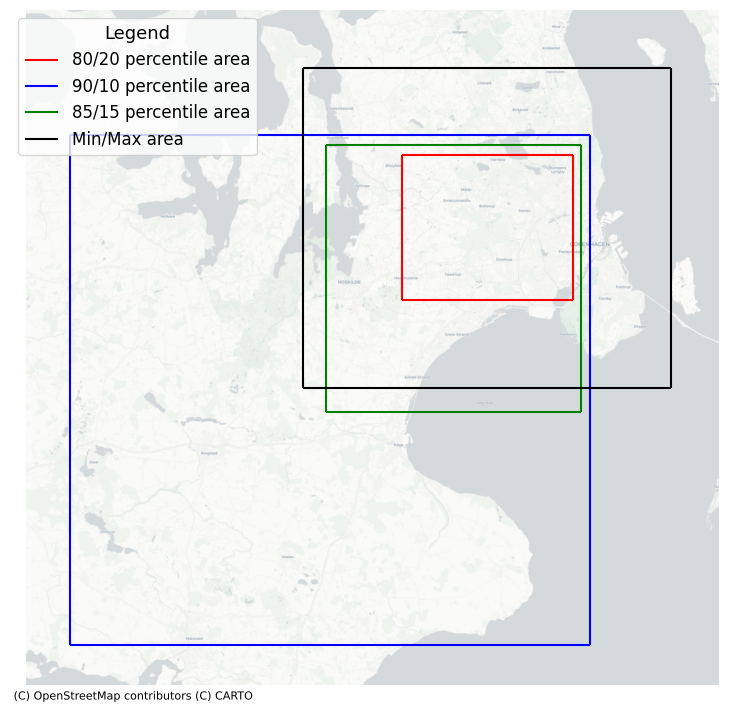

In [16]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

# Define the percentile coordinates as Shapely LineStrings
lines = {
    'red': [LineString([(lon_20, lat_20), (lon_80, lat_20)]),
            LineString([(lon_20, lat_80), (lon_80, lat_80)]),
            LineString([(lon_20, lat_20), (lon_20, lat_80)]),
            LineString([(lon_80, lat_20), (lon_80, lat_80)])],
    'blue': [LineString([(lon_10, lat_10), (lon_90, lat_10)]),
             LineString([(lon_10, lat_90), (lon_90, lat_90)]),
             LineString([(lon_10, lat_10), (lon_10, lat_90)]),
             LineString([(lon_90, lat_10), (lon_90, lat_90)])],
    'green': [LineString([(lon_15, lat_15), (lon_85, lat_15)]),
              LineString([(lon_15, lat_85), (lon_85, lat_85)]),
              LineString([(lon_15, lat_15), (lon_15, lat_85)]),
              LineString([(lon_85, lat_15), (lon_85, lat_85)])],
    'black': [LineString([(lon_min, lat_min), (lon_max, lat_min)]),
              LineString([(lon_min, lat_max), (lon_max, lat_max)]),
              LineString([(lon_min, lat_min), (lon_min, lat_max)]),
              LineString([(lon_max, lat_min), (lon_max, lat_max)])],
}

# Convert the LineStrings to GeoDataFrames
gdf = gpd.GeoDataFrame(geometry=[geom for color in lines.values() for geom in color])

# Set the CRS for the GeoDataFrame to WGS84 (lat/lon)
gdf.crs = "EPSG:4326"

# Convert the GeoDataFrame to Web Mercator for use with contextily
gdf = gdf.to_crs(epsg=3857)

# Adjusting the plot limits (zooming out)

# Calculate bounds
bounds = gdf.total_bounds
x_min, y_min, x_max, y_max = bounds
padding_x = (x_max - x_min) * 0.1  # 10% padding on each side
padding_y = (y_max - y_min) * 0.1  # 10% padding on each side

# Plotting with adjustments
fig, ax = plt.subplots(figsize=(16, 9))

custom_labels = {
    'red': '80/20 percentile area',
    'blue': '90/10 percentile area',
    'green': '85/15 percentile area',
    'black': 'Min/Max area',
}

# Plot each line by color with label for legend
for color, line_geoms in lines.items():
    gdf_line = gpd.GeoDataFrame(geometry=line_geoms)
    gdf_line.crs = "EPSG:4326"
    gdf_line = gdf_line.to_crs(epsg=3857)
    gdf_line.plot(ax=ax, color=color, label=custom_labels[color])

# Add the basemap from contextily with zoom out
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom= 11)

# Adjust plot limits with padding
ax.set_xlim(x_min - padding_x, x_max + padding_x)
ax.set_ylim(y_min - 2*padding_y, y_max + 2*padding_y)

# Adding a legend
ax.legend(title="Legend", title_fontsize="13", fontsize="12", loc="upper left")

# Remove the x and y axis for a cleaner look
ax.set_axis_off()

# Save the plot to a file
plt.savefig("percentile_map_plot.png", dpi=300)

plt.show()


Observation: All squares are shifted to the left side of the map, so that the squares are not centered around the middle of the DTU lyngby or Copenhagen. Assumption: frequent travels home to jutland or longer travels to other western countries affect the distribution of the coordinates. Since we are interested in trajectories on a city scale that follow rather exploitation patterns than exploration, we will only consider the metropolitain area of Copenhagen. We will therefore only consider the following coordinates:

```
lat_max= lat_80 + 0.1
lat_min= lat_20 - 0.1
lon_max= lon_80 + 0.2
lon_min= lon_20 - 0.2


In [ ]:
lat_max, lat_min, lon_max, lon_min

(55.88796262687908, 55.52217281782121, 12.734717261629013, 11.987848798727102)

In [ ]:
#calculate the distance between the max and min latitude and longitude in meters

from geopy.distance import geodesic
from geopy.distance import great_circle

dist1 = geodesic((lat_max, lon_max), (lat_max, lon_min)).meters
dist2 = geodesic((lat_max, lon_max), (lat_min, lon_max)).meters
dist1, dist2

(46733.68471304158, 40725.7407886375)

In [ ]:
dist1/1000, dist2/1000
# (194.53372572052973, 180.14178760114362)

(46.733684713041576, 40.7257407886375)

the szie of the grid cells is around 195 x 180 meters

In [ ]:
# seperate lat_max, lat_min and lon_max,lon_min into 200 bins
lat_bins = np.linspace(lat_min, lat_max, 1000)
lon_bins = np.linspace(lon_min, lon_max, 1000)

In [ ]:
# enumerate the bins
lat_bin_dict = dict(enumerate(lat_bins))
lon_bin_dict = dict(enumerate(lon_bins))

In [ ]:
# seperate the coordinates of the stops into the bins and add the bin numbers to the dataframe
df['lat_bin'] = np.digitize(df['latitude'], lat_bins)
df['lon_bin'] = np.digitize(df['longitude'], lon_bins)



In [ ]:
df.head()

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416,715,710
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609,710,714
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609,710,714
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609,710,714
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609,710,714


<Axes: xlabel='lat_bin'>

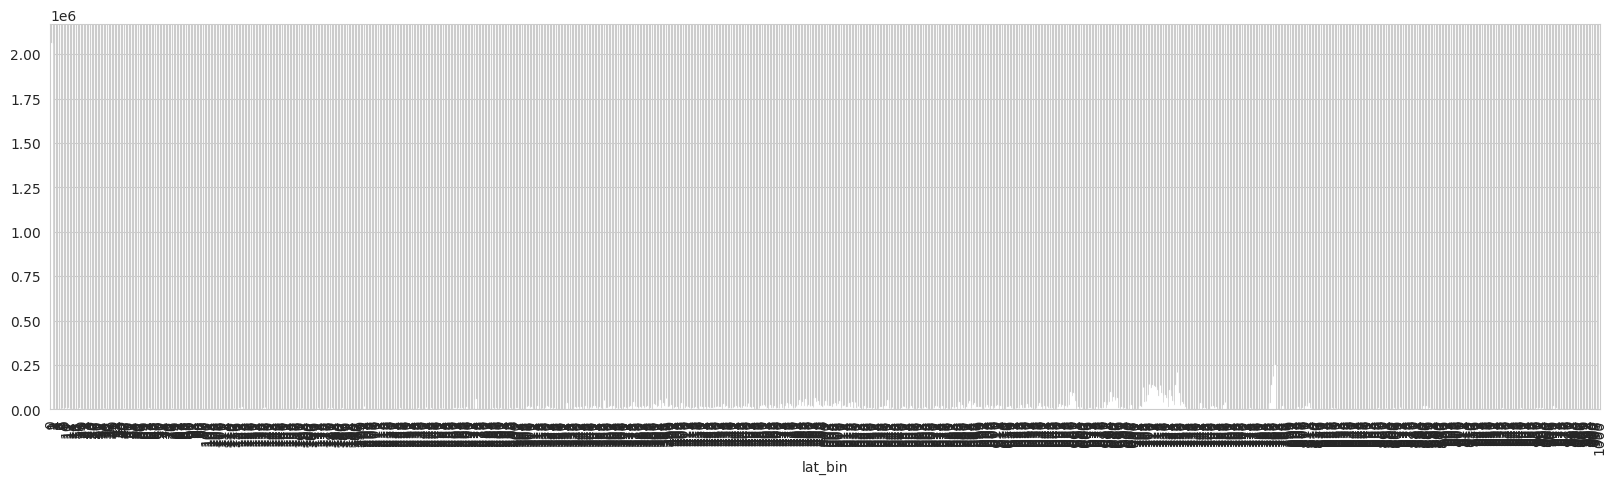

In [ ]:
df.lat_bin.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

<Axes: xlabel='lon_bin'>

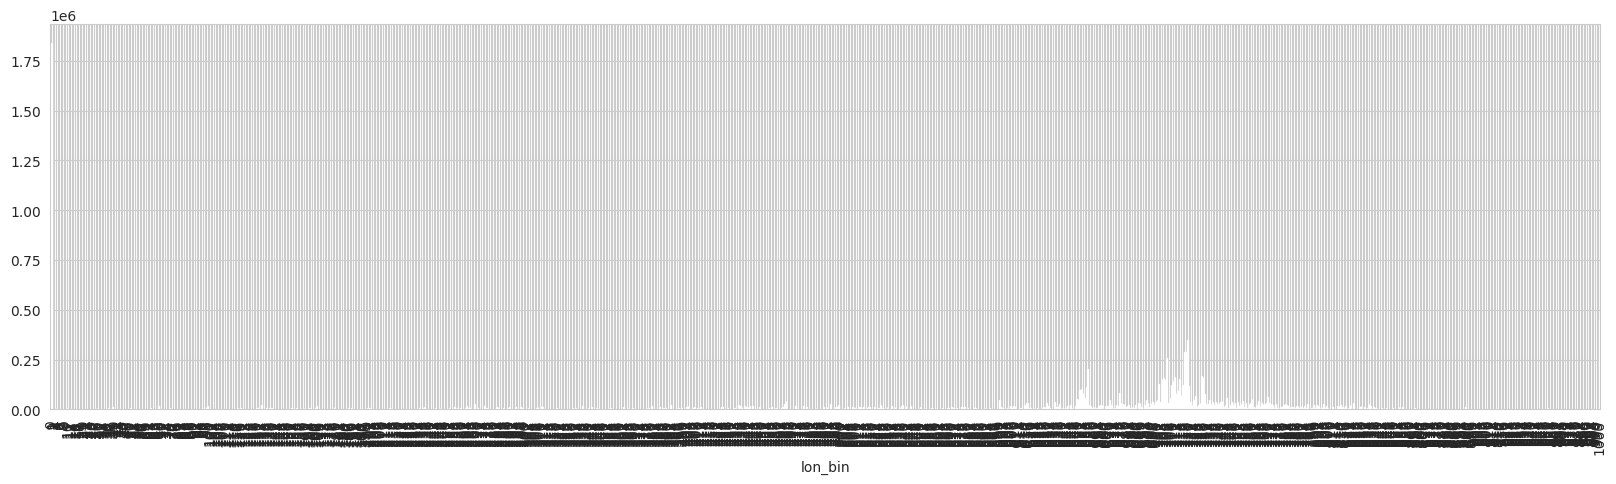

In [ ]:
df.lon_bin.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

comment: the selected grid seems to capture the center of the movement patterns of the users. Both the latitude and the longitude has outliers. The outliers for the latiture are more heavy in the lower end (south) than in the upper end (north) where as the outliers for longitude are heavily in the lower end (west) than in the upper end (east). 

In [ ]:
df.head()

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416,715,710
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609,710,714
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609,710,714
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609,710,714
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609,710,714


In [ ]:
# save fila as picke
df.to_pickle('../data/data_discretised_1000.pkl')

## Example
Pick one user and plot the trajectory on the map 

In [ ]:
df

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin
0,0.0,2013,10,31,12,1.0,2013-10-31 12:16:30,98,55.783644,12.518416,71,71
1,0.0,2013,10,31,12,2.0,2013-10-31 12:30:44,28,55.781990,12.521609,71,71
2,0.0,2013,10,31,13,1.0,2013-10-31 13:01:29,28,55.781990,12.521609,71,71
3,0.0,2013,10,31,13,2.0,2013-10-31 13:30:59,28,55.781990,12.521609,71,71
4,0.0,2013,10,31,14,1.0,2013-10-31 14:00:52,28,55.781990,12.521609,71,71
...,...,...,...,...,...,...,...,...,...,...,...,...
12827787,851.0,2015,8,7,20,1.0,2015-08-07 20:03:13,26,56.123877,9.849060,100,0
12827788,851.0,2015,8,7,20,2.0,2015-08-07 20:33:14,26,56.123877,9.849060,100,0
12827789,851.0,2015,8,7,21,1.0,2015-08-07 21:03:15,26,56.123877,9.849060,100,0
12827790,851.0,2015,8,7,21,2.0,2015-08-07 21:33:15,26,56.123877,9.849060,100,0


In [ ]:
# select user 153 in month 12, day 5 and hour 10 and plot the stops on a map
df_user = df[(df['user'] == 452) &(df['year'] == 2013) & (df['month'] == 10) & (df['day'] == 5) ]

In [ ]:
df_user

,user,year,month,day,hour,30min_interval,timestamp,stoplocation,latitude,longitude,lat_bin,lon_bin
8032177,452.0,2013,10,5,0,1.0,2013-10-05 00:01:33,2,55.636461,11.298771,31,0
8032178,452.0,2013,10,5,0,2.0,2013-10-05 00:30:33,2,55.636461,11.298771,31,0
8032179,452.0,2013,10,5,1,1.0,2013-10-05 01:00:34,2,55.636461,11.298771,31,0
8032180,452.0,2013,10,5,1,2.0,2013-10-05 01:30:34,2,55.636461,11.298771,31,0
8032181,452.0,2013,10,5,2,1.0,2013-10-05 02:00:34,2,55.636461,11.298771,31,0
8032182,452.0,2013,10,5,2,2.0,2013-10-05 02:30:32,2,55.636461,11.298771,31,0
8032183,452.0,2013,10,5,3,1.0,2013-10-05 03:00:33,2,55.636461,11.298771,31,0
8032184,452.0,2013,10,5,3,2.0,2013-10-05 03:30:34,2,55.636461,11.298771,31,0
8032185,452.0,2013,10,5,4,1.0,2013-10-05 04:00:26,2,55.636461,11.298771,31,0
8032186,452.0,2013,10,5,4,2.0,2013-10-05 04:30:27,2,55.636461,11.298771,31,0


/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


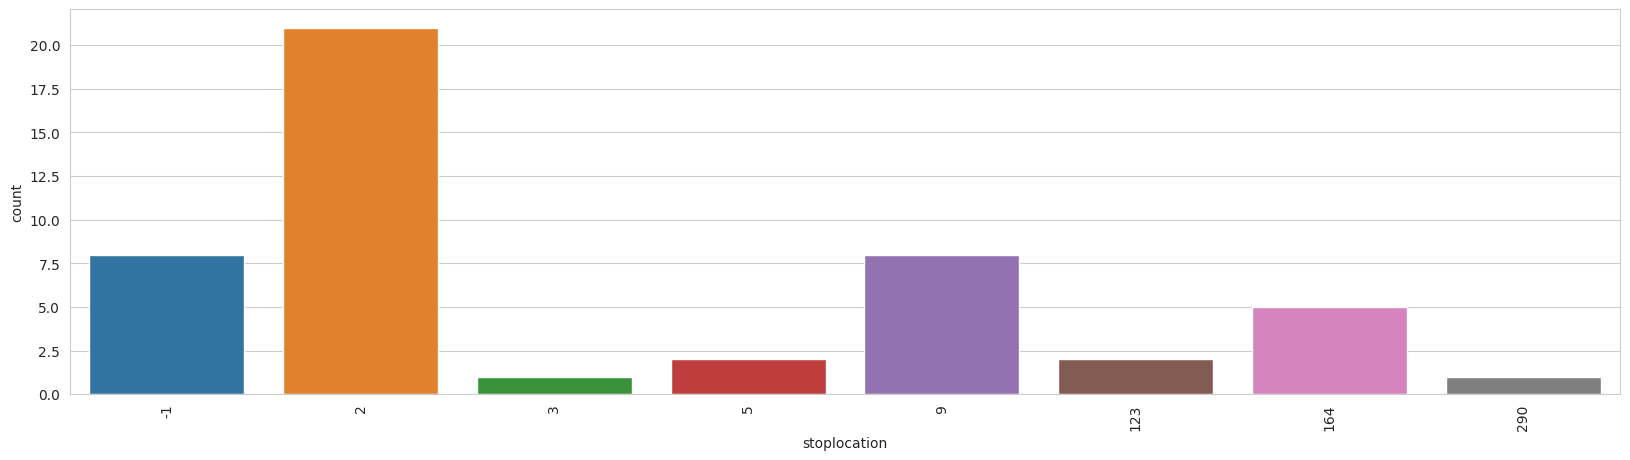

In [ ]:
# make a plot with a histogram of the stop locations
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(x='stoplocation', data=df_user)
plt.show()



In [ ]:
# create a color dictionary for the stops in df_user
# import a discrete color palette from seaborn
colors = sns.color_palette("Paired", 500).as_hex()


# create a function that assigns unique colors to each stoplocation
def color_assigner(stoplocation):
    if stoplocation not in color_dict:
        # assign a random color to the stoplocation
        color_dict[stoplocation] = np.random.choice(colors)
    return color_dict[stoplocation]

# create a dictionary that assigns a color to each stoplocation
color_dict = {}
color_dict[-1] = '#D3D3D3' #light gray for -1 stoplocations
df_user['color'] = df_user['stoplocation'].apply(color_assigner)

/tmp/ipykernel_1036059/2323571471.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['color'] = df_user['stoplocation'].apply(color_assigner)


In [ ]:
# create a map
m = folium.Map([55.783641, 12.518414], zoom_start=15, tiles='cartodbpositron')

# add the stops to the map and color them according to the stoplocation they belong to
for i in range(len(df_user)):
    folium.CircleMarker([df_user.iloc[i]['latitude'], df_user.iloc[i]['longitude']],
                        radius=10,
                        color= False,
                        fill_color=df_user.iloc[i]['color'],
                        fill_opacity=0.5).add_to(m)
    
# plot the map
m